<a href="https://colab.research.google.com/github/JuanBricenoFigueroa/Juan.briceno.aplica/blob/master/Ultima_version_Svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Librerias 

In [59]:
import numpy as np 
import pandas as pd
import math
from matplotlib import pyplot as plt
from loguru import logger

###Funciones por separado para hacer funcionar DRM

In [1]:
    def loss(X,Y,w,b):
      ##Funcion de perdida asociada a nuestro problema
      n_samples, n_features = X.shape
      suma=[]
      for i in range(n_samples):
        suma.append(Y.iloc[i][0]*(np.dot(np.transpose(X)[i],w) - b))
      
      numpy=np.array(suma)
      opcion=np.ones(n_samples)-numpy
      array=np.fmax(np.zeros(n_samples),opcion)
    
      return np.mean(array)

In [2]:
  def valores_w_b(X, y,lambda_param,lr,C,n_iters):
      n_samples, n_features = X.shape
      y_ = np.where(y <= 0, -1, 1)
        
      w = np.zeros(n_features)
      b = 0 

      for _ in range(n_iters):
          for idx in range(n_samples): 
            x_i=X.iloc[idx][:] 
            valor=y_[idx] * (np.dot(x_i, w) - b)
            if valor >= 1:
              w -= lr * (2 * lambda_param * w)
            else:
              w -= lr * (2 * lambda_param * w - C*y_[idx]*(x_i))
              b -= lr * y_[idx]

      return w,b

In [4]:
  def valores_w_b_perturbado_2(X, y, w_t, b_t,w_p,b_p,n_iters,lr):
      n_samples, n_features = X.shape
      y_ = np.where(y <= 0, -1, 1)
      w_e = w_t
      b_e = b_t
      for _ in range(n_iters):
          for idx in range(n_samples): 
            x_i=X.iloc[idx][:] 
            valor=y_[idx] * (np.dot(x_i, w_e) - b_e)
            if valor >= 1:
              w_e -= lr * (2 * 0.5 * (w_t + w_p))
            else:
              w_e -= lr * (2 * 0.5 * (w_t + w_p) - y_[idx]*(x_i))
              b_e -= lr * y_[idx]
      
      return w_e,b_e

In [5]:
def batch(dataset,num):
    batches = []
    num_split_examples = len( dataset )

    split_indices = np.arange(num_split_examples)
    shuffled_split_indices = np.random.permutation( split_indices )

    batch_size = num
    num_batches = int(math.ceil( num_split_examples * 1.0 / batch_size ))
    for batch_idx in range(num_batches):
        if ( num_split_examples % batch_size !=0) and (batch_idx == num_batches - 1):  # the last batch has wrong number
            start = batch_idx * batch_size  # standard case

            standard_batch_indices = list(shuffled_split_indices[start:])
            end = num_split_examples
            assert len(standard_batch_indices) == end - start

            num_missing = batch_size - len(standard_batch_indices)
            extra_indices = list(np.random.choice(num_split_examples, num_missing))
            batch_indices = standard_batch_indices + extra_indices
        else:
            start = batch_idx * batch_size  # standard case
            end = start + batch_size
            batch_indices = list(shuffled_split_indices[start:end])
        batches.append(batch_indices)
    return batches 


In [6]:
def DRM(dataset,gamma,num):
  #Paso 0:
  batches=batch(dataset,num)
  lista_params=[]
  np.random.seed(0)
  w_p_lista=np.random.rand(*(num,2))
  b_p_lista=np.random.rand(num)
  r=np.round(dataset.shape[0]/num,decimals=0)
  r=math.ceil(r)
  
  ##Aqui deseo que me seleccione las columnas (en el ejemplo es facil pues son 2 variables, pero en el caso que sean n)
  X=dataset[[dataset.columns[0],dataset.columns[1]]]
  y=dataset[[dataset.columns[2]]]

  w_t,b_t=valores_w_b(X,y,0.5,0.01,1,2000)

  for i in batches:
    datos=dataset[dataset.index.isin(i)]
    X=datos[[datos.columns[0],datos.columns[1]]]
    X=X.reset_index()
    X=X[[X.columns[1],X.columns[2]]]
    y=datos[[datos.columns[2]]]
    y=y.reset_index()
    y=y[[y.columns[1]]]

  #Paso 1:
    lista_final=[]
    contador=0
    for w_p_i in w_p_lista:
       for b_p_i in b_p_lista:
         aux=[w_p_i[0],w_p_i[1],b_p_i]
         vector=np.array(aux)
         a_1=np.round(np.linalg.norm(vector),decimals=1)
         lista_aux=[]
         ## Normalizar los vectores y multiplicar por gamma
         if a_1 == gamma:
           contador+=1
           lista_aux.append(w_p_i)
           lista_aux.append(b_p_i)
           lista_final.append(lista_aux)
         else:
           contador+=1
           #print('No entro')
  #Paso 2:
  ## Esto es una idea del profe
  ## Maximizar de u en U y sobre tau en (0,1) l(w_t+tua*u)
    lista_valores=[]
    lista_params_aux=[]
    for i in lista_final:
      w_t_1=w_t+i[0]
      b_t_1=b_t+i[1]
      a=loss(X,y,w_t_1,b_t_1)
      lista_valores_aux=[]
      lista_valores_aux.append(i[0])
      lista_valores_aux.append(i[1])
      lista_valores_aux.append(a)
      lista_valores.append(lista_valores_aux)

    df=pd.DataFrame(lista_valores)
    ### Selecion maximo segun la perdida que nos entregue
    columnas=df.columns
    num_maximo=df[df[columnas[2]] == df[columnas[2]].max()]
    #Paso 3:
    array_maximo=np.array(num_maximo.iloc[0][0])
    #print(array_maximo)
    b_maximo=num_maximo.iloc[0][1]
    #print(b_maximo)
    ### Entrenar a SVM perturbado paso calcular proyeccion 
    w_t,b_t=valores_w_b_perturbado_2(X,y,w_t,b_t,array_maximo,b_maximo,350,0.01)
    lista_params_aux.append(w_t)
    lista_params_aux.append(b_t)
    lista_params.append(lista_params_aux)
  
  pandas=pd.DataFrame(lista_params)

  return w_t,b_t,pandas


In [9]:
## Funcion que nos entrega un vector normalizado con norma 2 y norma gamma:
def normal_gamma(v,gamma,inf):
  if inf == 'inf':
    norma = np.linalg.norm(v,ord=np.inf)
    if norma == 0 :
      return v
  else:
    norma = np.linalg.norm(v,ord=2)
    if norma == 0: 
       return v
  return gamma*(v / norma)

In [64]:
def DRM_nuevo(dataset,gamma,num,inf):
    #Paso 0:
    logger.info('Paso 0')
    batches=batch(dataset,num)
    lista_params=[]
    
    np.random.seed(0)
    r=np.round(dataset.shape[0]/num)
    w_b_p_lista=np.random.rand(*(num,3))
    
    X=dataset[[dataset.columns[0],dataset.columns[1]]]
    y=dataset[[dataset.columns[2]]]
    
    w_t,b_t=valores_w_b(X,y,0.5,0.01,1,1300)
    for i in batches:
        lista_params_aux=[]
        datos=dataset[dataset.index.isin(i)]
        X=datos[[datos.columns[0],datos.columns[1]]]
        X=X.reset_index()
        X=X[[X.columns[1],X.columns[2]]]
        y=datos[[datos.columns[2]]]
        y=y.reset_index()
        y=y[[y.columns[1]]]
        
        #Paso 1:
        logger.info('Paso 1')
        
        lista_final=[]
        for j in w_b_p_lista:
            a_1=normal_gamma(j,gamma,inf)
            lista_final.append(a_1)
            
        #Paso 2:
        logger.info('Paso 2')
        lista_valores=[]
        for i in lista_final:
            w_t_1=w_t+i[0:2]
            b_t_1=b_t+i[2]
            a=loss(X,y,w_t_1,b_t_1)
            lista_valores_aux=[]
            lista_valores_aux.append(i[0:2])
            lista_valores_aux.append(i[2])
            lista_valores_aux.append(a)
            lista_valores.append(lista_valores_aux)
            
        df=pd.DataFrame(lista_valores)
        ### Selecion maximo segun la perdida que nos entregue
        logger.info('Seleccion de maximo segun la perdida que nos entregue')
        columnas=df.columns
        num_maximo=df[df[columnas[2]] == df[columnas[2]].max()]
        #Paso 3:
        logger.info('Paso 3')
        
        array_maximo=np.array(num_maximo.iloc[0][0])
        b_maximo=num_maximo.iloc[0][1]
        ### Entrenar a SVM perturbado paso calcular proyeccion 
        logger.info('Entrenar SVM perturbado')
        w_t,b_t=valores_w_b_perturbado_2(X,y,w_t,b_t,array_maximo,b_maximo,300,0.01)
        lista_params_aux.append(w_t.copy())
        lista_params_aux.append(b_t.copy())
        lista_params.append(lista_params_aux)
    pandas=pd.DataFrame(lista_params)
    
    return w_t,b_t, pandas

In [61]:
def line_func(x, offset,w_t,b_t): #Definir el hiperplano separador, con respecto a los margenes que se pidieron
    return   -1 * (offset - b_t[0] + w_t[0] * x ) / w_t[1]

In [62]:
def grafico_solucion_DRM(w_t,b_t,valor):
  x = np.array(range(1, 5))
  ym = line_func(x,  0,w_t,b_t)
  y9 = line_func(x, 0,lista[16],lista[17])
  
  x_index = 2
  y_index = 3
  plt.figure(figsize=(8, 6))
  formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
  plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
  plt.colorbar(ticks=[0, 1, 2], format=formatter)
  plt.xlabel(iris.feature_names[x_index])
  plt.ylabel(iris.feature_names[y_index])
  plt.plot(x, ym)
  plt.plot(x, y9)
  plt.title('Solucion DRM con gamma'+valor)
  plt.legend(('perturbacion DRM','SVM'))

### Prueba con el Dataset Iris


In [7]:
from sklearn.datasets import load_iris

iris = load_iris()
X = [[x[2], x[3]] for x in iris.data]
y = iris.target.copy()
for i in range(len(y)): #Transformacion de los casos negativos a 1 y casos positivos a -1 
    if y[i] == 0: y[i] = 1
    else: y[i] = -1

X=pd.DataFrame(X)
X=X.rename(columns={0:'X1' , 1:'X2'})
y=pd.DataFrame(y)
y=y.rename(columns={0:'target'})
dataset= pd.concat([X, y], axis=1)


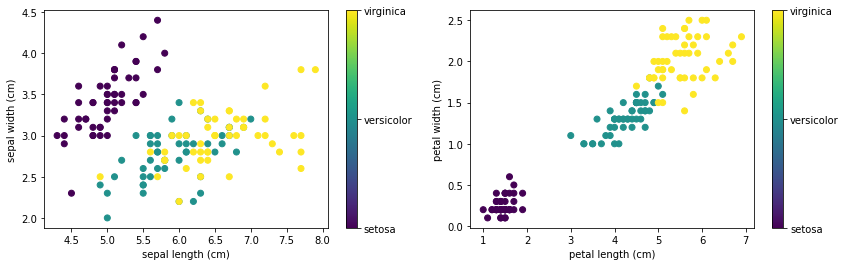

In [66]:
from sklearn.datasets import load_iris

def plot(x_index, y_index):
    formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
    plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
    plt.colorbar(ticks=[0, 1, 2], format=formatter)
    plt.xlabel(iris.feature_names[x_index])
    plt.ylabel(iris.feature_names[y_index])

iris = load_iris()
plt.figure(figsize=(14, 4))
plt.subplot(121)
plot(0, 1)
plt.subplot(122)
plot(2, 3)
plt.show()

#### Bandas de DRM

In [39]:
###Solucion del plano
w = [-0.7772138 , -1.5555406] 
b = -3.0742273
w.append(b)
w=np.array(w)
matrix=w+0.5,w-0.5
matrix=np.transpose(matrix)
w1=matrix[0]
w2=matrix[1]
b1=matrix[2]
lista_final=[]
for i in w1:
  for j in w2:
    for k in b1:
      lista=[]
      lista.append(i)
      lista.append(j)
      lista.append(k)
      lista_final.append(lista)
lista=[]
for i in lista_final:
  w1=np.array(i[0:2])
  b1=[]
  b1.append(i[2])
  lista.append(w1)
  lista.append(b1)
lista.append(np.array([-0.7772138 , -1.5555406]))
lista.append([-3.0742273])

In [42]:
def lista_rectas_perturbacion(perturbacion):
    w = [-0.7772138 , -1.5555406] 
    b = -3.0742273
    w.append(b)
    w=np.array(w)
    matrix=w+perturbacion,w-perturbacion
    matrix=np.transpose(matrix)
    w1=matrix[0]
    w2=matrix[1]
    b1=matrix[2]
    lista_final=[]
    for i in w1:
        for j in w2:
            for k in b1:
                lista=[]
                lista.append(i)
                lista.append(j)
                lista.append(k)
                lista_final.append(lista)
    lista=[]
    for i in lista_final:
        w1=np.array(i[0:2])
        b1=[]
        b1.append(i[2])
        lista.append(w1)
        lista.append(b1)
    lista.append(np.array([-0.7772138 , -1.5555406]))
    lista.append([-3.0742273])
    
    return lista

In [41]:
def graficos_DRM(lista,valor):
    x = np.array(range(1, 5))
    y1 = line_func(x,  0,lista[0],lista[1])
    y2 = line_func(x,  0,lista[2],lista[3])
    y3 = line_func(x, 0,lista[4],lista[5])
    y4 = line_func(x,  0,lista[6],lista[7])
    y5 = line_func(x,  0,lista[8],lista[9])
    y6 = line_func(x, 0,lista[10],lista[11])
    y7 = line_func(x,  0,lista[12],lista[13])
    y8 = line_func(x,  0,lista[14],lista[15])
    y9 = line_func(x, 0,lista[16],lista[17])
    
    x_index = 2
    y_index = 3
    plt.figure(figsize=(8, 6))
    formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
    plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
    plt.colorbar(ticks=[0, 1, 2], format=formatter)
    plt.xlabel(iris.feature_names[x_index])
    plt.ylabel(iris.feature_names[y_index])
    
    a=plt.plot(x, y1)
    b=plt.plot(x, y2)
    c=plt.plot(x, y3)
    d=plt.plot(x, y4)
    e=plt.plot(x, y5)
    f=plt.plot(x, y6)
    g=plt.plot(x, y7)
    h=plt.plot(x, y8)
    i=plt.plot(x, y9)
    
    plt.title('Grafico de perturbaciones para gamma='+valor)
    plt.legend(('perturbacion 1', 'perturbacion 2', 'perturbacion 3','perturbacion 4','perturbacion 5','perturbacion 6','perturbacion 7','perturbacion 8','SVM'))

In [43]:
lista=lista_rectas_perturbacion(0.5)
lista_1=lista_rectas_perturbacion(1.0)
lista_2=lista_rectas_perturbacion(1.5)
lista_3=lista_rectas_perturbacion(2.0)

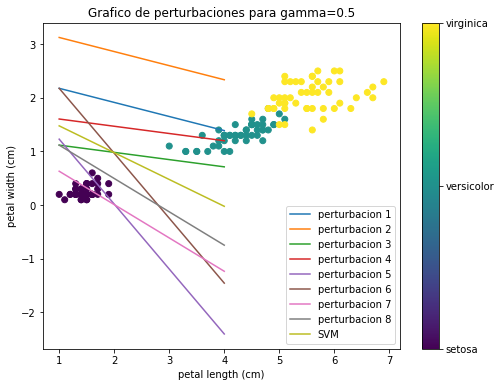

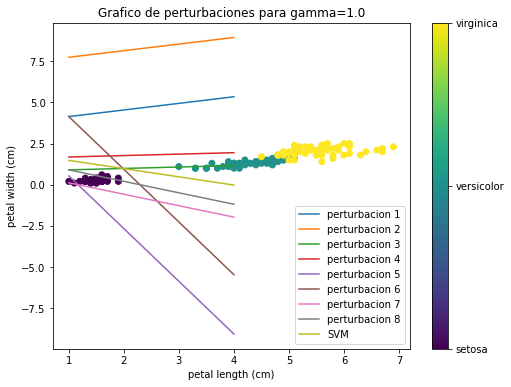

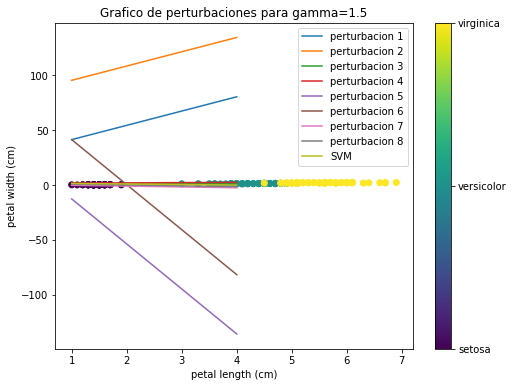

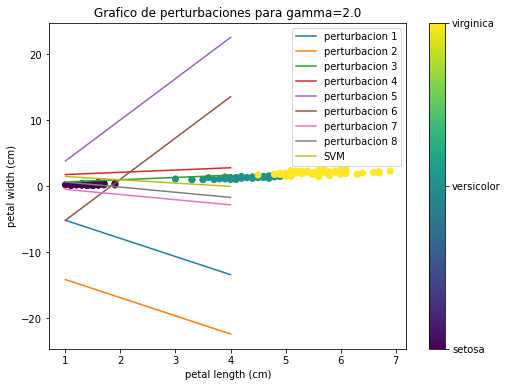

In [47]:
graficos_DRM(lista,'0.5')
graficos_DRM(lista_1,'1.0')
graficos_DRM(lista_2,'1.5')
graficos_DRM(lista_3,'2.0')

##### DRM con norma infinita


In [49]:
w_t,b_t,df=DRM_nuevo(dataset,0.5,20,'inf')
w_t_1,b_t_1,df_1=DRM_nuevo(dataset,1,20,'inf')
w_t_2,b_t_2,df_2=DRM_nuevo(dataset,1.5,20,'inf')
w_t_3,b_t_3,df_3=DRM_nuevo(dataset,2,20,'inf')

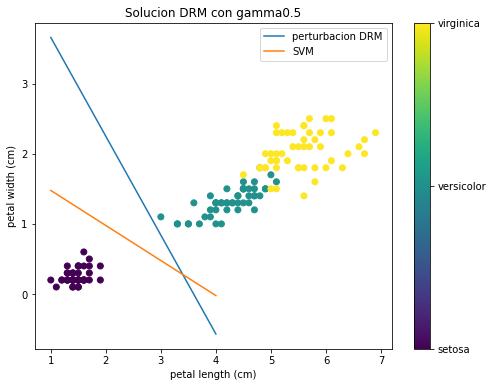

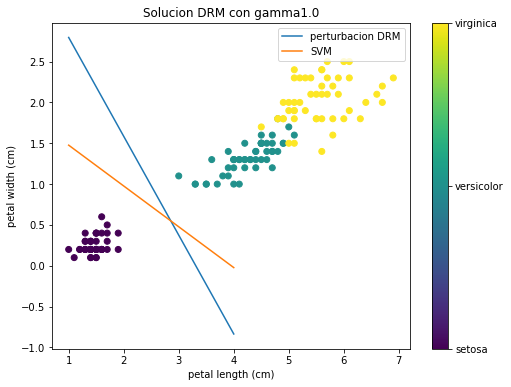

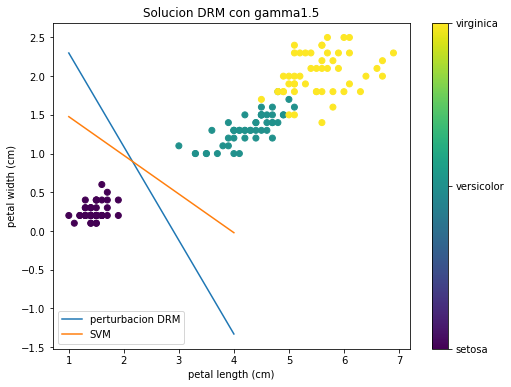

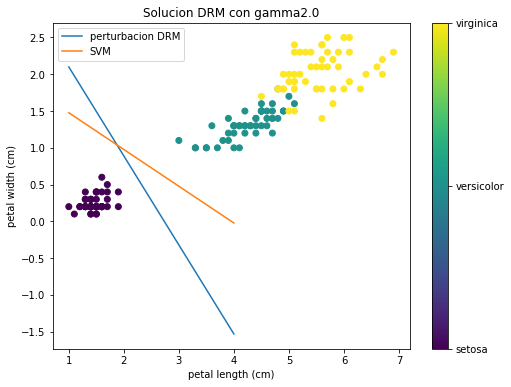

In [54]:
grafico_solucion_DRM(w_t,b_t,'0.5')
grafico_solucion_DRM(w_t_1,b_t_1,'1.0')
grafico_solucion_DRM(w_t_2,b_t_2,'1.5')
grafico_solucion_DRM(w_t_3,b_t_3,'2.0')

#### DRM con norma 2

In [65]:
w_t,b_t,df=DRM_nuevo(dataset,0.5,20,2)

2021-09-24 18:57:36.617 | INFO     | __main__:DRM_nuevo:3 - Paso 0
2021-09-24 19:00:57.661 | INFO     | __main__:DRM_nuevo:26 - Paso 1
2021-09-24 19:00:57.671 | INFO     | __main__:DRM_nuevo:34 - Paso 2
2021-09-24 19:00:57.951 | INFO     | __main__:DRM_nuevo:48 - Seleccion de maximo segun la perdida que nos entregue
2021-09-24 19:00:57.959 | INFO     | __main__:DRM_nuevo:52 - Paso 3
2021-09-24 19:00:57.961 | INFO     | __main__:DRM_nuevo:57 - Entrenar SVM perturbado
2021-09-24 19:01:05.481 | INFO     | __main__:DRM_nuevo:26 - Paso 1
2021-09-24 19:01:05.485 | INFO     | __main__:DRM_nuevo:34 - Paso 2
2021-09-24 19:01:05.801 | INFO     | __main__:DRM_nuevo:48 - Seleccion de maximo segun la perdida que nos entregue
2021-09-24 19:01:05.804 | INFO     | __main__:DRM_nuevo:52 - Paso 3
2021-09-24 19:01:05.807 | INFO     | __main__:DRM_nuevo:57 - Entrenar SVM perturbado
2021-09-24 19:01:13.072 | INFO     | __main__:DRM_nuevo:26 - Paso 1
2021-09-24 19:01:13.079 | INFO     | __main__:DRM_nuevo:3

In [55]:
w_t,b_t,df=DRM_nuevo(dataset,0.5,20,2)
w_t_1,b_t_1,df_1=DRM_nuevo(dataset,1,20,2)
w_t_2,b_t_2,df_2=DRM_nuevo(dataset,1.5,20,2)
w_t_3,b_t_3,df_3=DRM_nuevo(dataset,2,20,2)

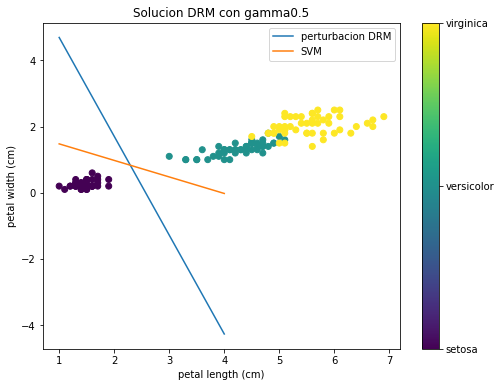

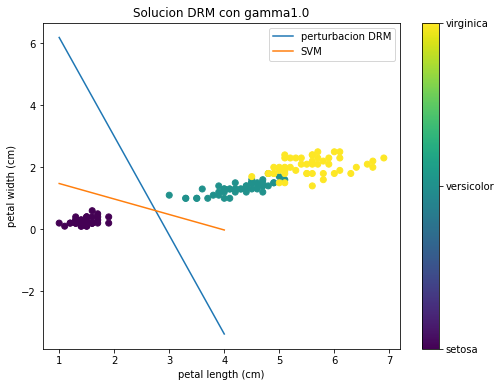

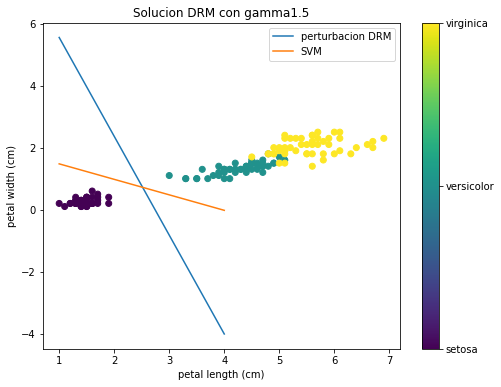

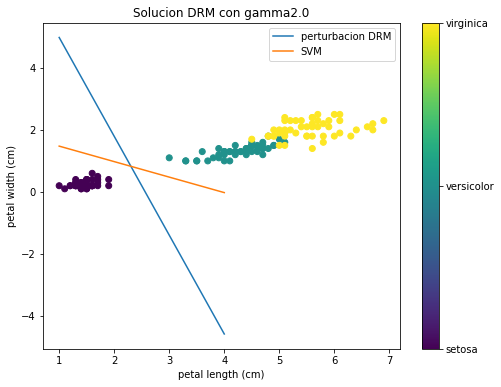

In [56]:
grafico_solucion_DRM(w_t,b_t,'0.5')
grafico_solucion_DRM(w_t_1,b_t_1,'1.0')
grafico_solucion_DRM(w_t_2,b_t_2,'1.5')
grafico_solucion_DRM(w_t_3,b_t_3,'2.0')

#### Pruebas DRM infinito con bases canonicas

In [8]:
## Estoy generando perturbaciones canonicas, en este caso seria algo del siguiente estilo:

U_=[[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,-1],[0,0,1]]
U=[]
for i in U_:
  U.append(np.array(i))

In [ ]:
### Nueva variante de DRM en el cual utilizamos las perturbaciones canonicas U y se les multiplica por gamma para que tengan norma gamma (Idea para ver cual es la componente mas sensible)

def DRM_nuevo_e(dataset,gamma,num,inf):
  #Paso 0:
  batches=batch(dataset,num)
  lista_params=[]
  np.random.seed(0)
  w_b_p_lista= U 
  r=np.round(dataset.shape[0]/num)

  X=dataset[[dataset.columns[0],dataset.columns[1]]]
  y=dataset[[dataset.columns[2]]]

  w_t,b_t=valores_w_b(X,y,0.5,0.01,1,1300)

  for i in batches:
    datos=dataset[dataset.index.isin(i)]
    X=datos[[datos.columns[0],datos.columns[1]]]
    X=X.reset_index()
    X=X[[X.columns[1],X.columns[2]]]
    y=datos[[datos.columns[2]]]
    y=y.reset_index()
    y=y[[y.columns[1]]]

  #Paso 1:
    lista_final=[]
    for j in w_b_p_lista:
      a=normal_gamma(j,gamma,inf)
      lista_final.append(a)
  #Paso 2:
  ## Maximizar de u en U y sobre tau en (0,1) l(w_t+tua*u)
    lista_valores=[]
    lista_params_aux=[]
    for i in lista_final:
       w_t_1=w_t+i[0:2]
       b_t_1=b_t+i[2]
       a=loss(X,y,w_t_1,b_t_1)
       lista_valores_aux=[]
       lista_valores_aux.append(i[0:2])
       lista_valores_aux.append(i[2])
       lista_valores_aux.append(a)
       lista_valores.append(lista_valores_aux)
    df=pd.DataFrame(lista_valores)
    
    ### Selecion maximo segun la perdida que nos entregue
    columnas=df.columns
    num_maximo=df[df[columnas[2]] == df[columnas[2]].max()]
    #Paso 3:
    array_maximo=np.array(num_maximo.iloc[0][0])
    b_maximo=num_maximo.iloc[0][1]
    ### Entrenar a SVM perturbado paso calcular proyeccion 
    w_t,b_t=valores_w_b_perturbado_2(X,y,w_t,b_t,array_maximo,b_maximo,400,0.01)
    print(w_t)
    print(b_t)
    lista_params_aux.append(w_t)
    lista_params_aux.append(b_t)
    lista_params.append(lista_params_aux)
  pandas=pd.DataFrame(lista_params)

  return w_t,b_t, pandas

In [ ]:
w_t,b_t,df=DRM_nuevo_e(dataset,0.5,20,'inf')

X1   -0.701225
X2   -0.072320
Name: 0, dtype: float64
[-1.99]
X1   -0.806893
X2   -0.138898
Name: 0, dtype: float64
[-2.25]
X1   -0.742475
X2   -0.075197
Name: 0, dtype: float64
[-2.02]
X1   -0.797670
X2   -0.143525
Name: 0, dtype: float64
[-2.18]
X1   -0.632444
X2   -0.054662
Name: 0, dtype: float64
[-2.01]
X1   -0.709284
X2   -0.073763
Name: 0, dtype: float64
[-2.01]
X1   -0.788929
X2   -0.105226
Name: 0, dtype: float64
[-2.15]
X1   -0.711671
X2   -0.088533
Name: 0, dtype: float64
[-2.08]


In [ ]:
w_t_1,b_t_1,df_1=DRM_nuevo_e(dataset,1,20,'inf')

X1   -1.000000e+00
X2    8.735339e-19
Name: 0, dtype: float64
[-2.51]
X1   -1.081778
X2   -0.042351
Name: 0, dtype: float64
[-3.02]
X1   -1.084025
X2   -0.018334
Name: 0, dtype: float64
[-2.73]
X1   -1.077965
X2   -0.048582
Name: 0, dtype: float64
[-2.73]
X1   -1.000000e+00
X2   -5.613109e-37
Name: 0, dtype: float64
[-2.74]
X1   -1.089316
X2   -0.032343
Name: 0, dtype: float64
[-2.83]
X1   -1.078980
X2   -0.030837
Name: 0, dtype: float64
[-2.72]
X1   -1.000000e+00
X2   -1.154712e-33
Name: 0, dtype: float64
[-2.72]


In [ ]:
w_t,b_t,df=DRM_nuevo_e(dataset,0.5,20,'inf')
w_t_1,b_t_1,df=DRM_nuevo_e(dataset,1,20,'inf')
w_t_2,b_t_2,df=DRM_nuevo_e(dataset,1.5,20,'inf')
w_t_3,b_t_3,df=DRM_nuevo_e(dataset,2,20,'inf')

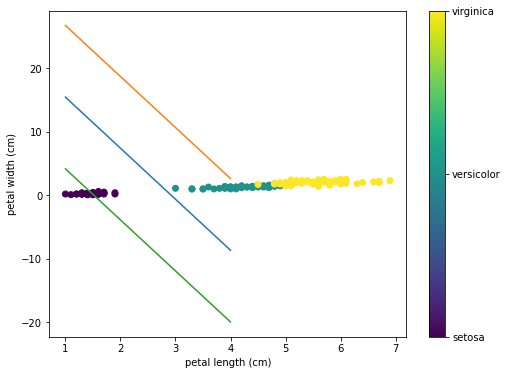

In [ ]:
###GAMMA = 0.5
x = np.array(range(1, 5))
ym = line_func(x,  0,w_t,b_t)
yp = line_func(x,  1,w_t,b_t)
yn = line_func(x, -1,w_t,b_t)
x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)

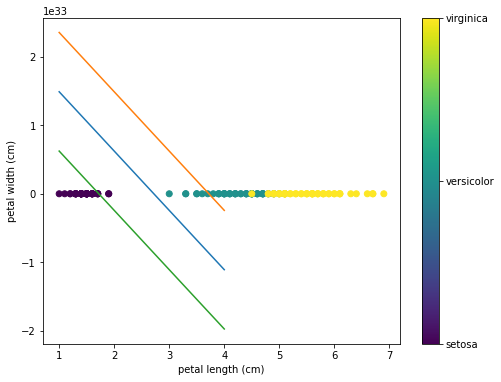

In [ ]:
###GAMMA = 1
x = np.array(range(1, 5))
ym = line_func(x,  0,w_t_1,b_t_1)
yp = line_func(x,  1,w_t_1,b_t_1)
yn = line_func(x, -1,w_t_1,b_t_1)

x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)

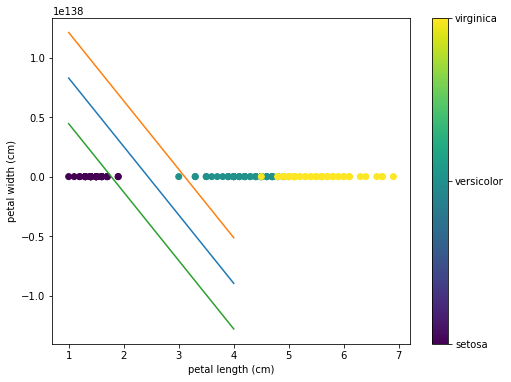

In [ ]:
###GAMMA = 1.5
x = np.array(range(1, 5))
ym = line_func(x,  0,w_t_2,b_t_2)
yp = line_func(x,  1,w_t_2,b_t_2)
yn = line_func(x, -1,w_t_2,b_t_2)

x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)

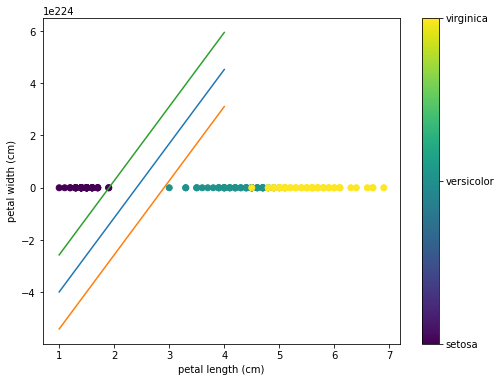

In [ ]:
###GAMMA = 2.0
x = np.array(range(1, 5))
ym = line_func(x,  0,w_t_3,b_t_3)
yp = line_func(x,  1,w_t_3,b_t_3)
yn = line_func(x, -1,w_t_3,b_t_3)

x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)

#### Pruebas DRM norma 2 con bases canonicas

In [ ]:
w_t,b_t,df=DRM_nuevo_e(dataset,0.5,20,2)

X1   -0.701225
X2   -0.072320
Name: 0, dtype: float64
[-1.99]
X1   -0.806893
X2   -0.138898
Name: 0, dtype: float64
[-2.25]
X1   -0.742475
X2   -0.075197
Name: 0, dtype: float64
[-2.02]
X1   -0.797670
X2   -0.143525
Name: 0, dtype: float64
[-2.18]
X1   -0.632444
X2   -0.054662
Name: 0, dtype: float64
[-2.01]
X1   -0.709284
X2   -0.073763
Name: 0, dtype: float64
[-2.01]
X1   -0.788929
X2   -0.105226
Name: 0, dtype: float64
[-2.15]
X1   -0.711671
X2   -0.088533
Name: 0, dtype: float64
[-2.08]


In [ ]:
w_t_1,b_t_1,df_1=DRM_nuevo_e(dataset,1,20,2)

X1   -1.000000e+00
X2    8.735339e-19
Name: 0, dtype: float64
[-2.51]
X1   -1.081778
X2   -0.042351
Name: 0, dtype: float64
[-3.02]
X1   -1.084025
X2   -0.018334
Name: 0, dtype: float64
[-2.73]
X1   -1.077965
X2   -0.048582
Name: 0, dtype: float64
[-2.73]
X1   -1.000000e+00
X2   -5.613109e-37
Name: 0, dtype: float64
[-2.74]
X1   -1.089316
X2   -0.032343
Name: 0, dtype: float64
[-2.83]
X1   -1.078980
X2   -0.030837
Name: 0, dtype: float64
[-2.72]
X1   -1.000000e+00
X2   -1.154712e-33
Name: 0, dtype: float64
[-2.72]


In [ ]:
w_t,b_t,df=DRM_nuevo_e(dataset,0.5,20,2)
w_t_1,b_t_1,df=DRM_nuevo_e(dataset,1,20,2)
w_t_2,b_t_2,df=DRM_nuevo_e(dataset,1.5,20,2)
w_t_3,b_t_3,df=DRM_nuevo_e(dataset,2,20,2)

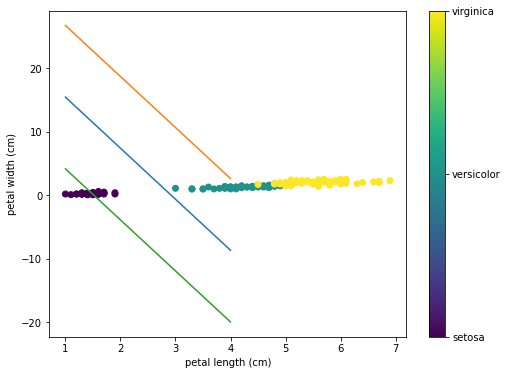

In [ ]:
###GAMMA = 0.5
x = np.array(range(1, 5))
ym = line_func(x,  0,w_t,b_t)
yp = line_func(x,  1,w_t,b_t)
yn = line_func(x, -1,w_t,b_t)
x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)

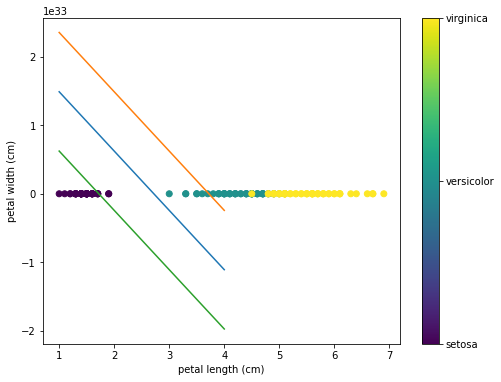

In [ ]:
###GAMMA = 1
x = np.array(range(1, 5))
ym = line_func(x,  0,w_t_1,b_t_1)
yp = line_func(x,  1,w_t_1,b_t_1)
yn = line_func(x, -1,w_t_1,b_t_1)
x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)

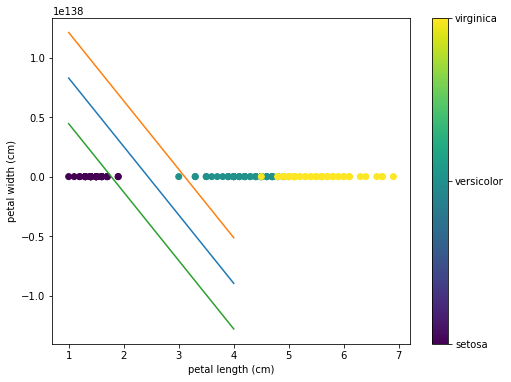

In [ ]:
###GAMMA = 1.5
x = np.array(range(1, 5))
ym = line_func(x,  0,w_t_2,b_t_2)
yp = line_func(x,  1,w_t_2,b_t_2)
yn = line_func(x, -1,w_t_2,b_t_2)
x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)

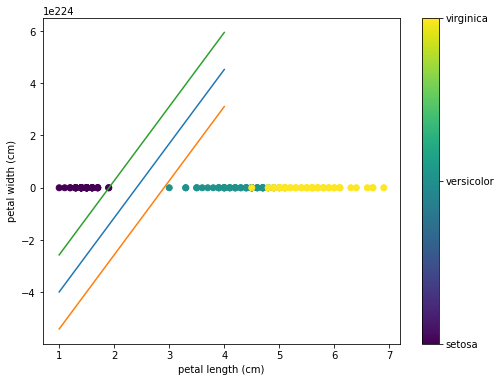

In [ ]:
###GAMMA = 2
x = np.array(range(1, 5))
ym = line_func(x,  0,w_t_3,b_t_3)
yp = line_func(x,  1,w_t_3,b_t_3)
yn = line_func(x, -1,w_t_3,b_t_3)
x_index = 2
y_index = 3
plt.figure(figsize=(8, 6))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
plt.colorbar(ticks=[0, 1, 2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.plot(x, ym)
plt.plot(x, yp)
plt.plot(x, yn)

In [ ]:
## Idea para agregar aleatoriedad y ver si se tienen mejores resultados

def valores_rand_gamma(num,gamma,norm):
  lista_w_p=np.random.rand(*(num,2))
  lista_b_p=np.random.rand(num)
  lista=[]
  for w_p_i in lista_w_p:
    for b_p_i in lista_b_p:
      aux=[w_p_i[0],w_p_i[1],b_p_i]
      vector=np.array(aux)
      if norm == 'inf':
        a_2=np.linalg.norm(vector,ord=np.inf)
        vector=gamma*(vector/a_2)
        lista.append(vector)
      else:
        a_2=np.linalg.norm(vector,ord=2)
        vector=gamma*(vector/a_2)
        lista.append(vector)
  
  return lista


#### Pruebas 

In [ ]:
lista=[45, 96, 88, 4, 21, 50, 59, 117, 119, 90]
dataset=dataset[dataset.index.isin(lista)]
dataset.reset_index()
np.array(dataset.iloc[0][0:2])

array([1.4, 0.2])

In [ ]:
## Error ()
### el problema de aqui es que no me deja generar el .fit o el .valores_w_b en un for (en el for del DRM) y eso no se porque se da
class SVM:

    def __init__(self,C=1, learning_rate=0.001, lambda_param=0.01, n_iters=100):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.C= C


    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        y_ = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0
        for _ in range(self.n_iters):
          for idx in range(n_samples):
            x_i=X.iloc[idx][:] 
            valor=y_[idx] * (np.dot(x_i,self.w) - self.b)
            if valor >= 1:
              self.w -= self.lr * (2 * self.lambda_param * self.w)
            else:
                self.w -= self.lr * (2 * self.lambda_param * self.w - self.C*y[idx]*(x_i))
                self.b -= self.lr * y_[idx]


    def valores_w_b(self,X,y):
      n_samples, n_features = X.shape
      y_ = np.where(y <= 0, -1, 1)
      w = np.zeros(n_features)
      b = 0
      for _ in range(self.n_iters):
        for idx in range(n_samples):
          x_i=X.iloc[idx][:]
          valor=y_[idx] * (np.dot(x_i, w) - b)
          if valor >= 1:
            self.w -= self.lr * (2 * self.lambda_param * w)
          else:
            self.w -= self.lr * (2 * self.lambda_param * w - self.C*y_[idx]*(x_i))
            self.b -= self.lr * y_[idx]
      return w,b

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

    def loss(X,Y,w,b):
      n_samples, n_features = X.shape
      suma=[]
      for i in range(n_samples):
        suma.append(Y.iloc[i][0]*(np.dot(np.transpose(X)[i],w) - b))
      
      numpy=np.array(suma)
      opcion=np.ones(n_samples)-numpy
      array=np.fmax(np.zeros(n_samples),opcion)
    
      return np.mean(array)


In [ ]:
#Duda:
## Aqui tengo una duda mas que nada en la actualizacion de los parametros del vector W y b , porque segun el papper es:
## w_t+1= proy(w_t - \lambda * \nabla_{(w,b)}R_{B_t}(w_p,b_p)
## w_p , b_p son los valores perturbados 
def valores_w_b_perturbado(X, y, w_p, b_p,n_iters,lr):
  n_samples, n_features = X.shape
  y_ = np.where(y <= 0, -1, 1)
  w_e = w_p
  b_e = b_p
  for _ in range(n_iters):
    for idx in range(n_samples):
      x_i=X.iloc[idx][:]
      valor=y_[idx] * (np.dot(x_i, w_e) - b_e)
      if valor >= 1:
        w_e -= lr * (2 * 0.5 * w_e)
      else:
        w_e -= lr * (2 * 0.5 * w_e - y_[idx]*(x_i))
        b_e -= lr * y_[idx]
  return w_e,b_e